In [ ]:
import os
import random
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

TRAIN_PATH = '../data/train_clean.csv'
TEST_PATH = '../data/test_clean.csv'

# Cargar datasets
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("-Archivos cargados-")
print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")

print("\n--- Primeras 5 filas de train ---")
display(train.head())

print("\n--- Tipos de columnas (train) ---")
print(train.dtypes.value_counts())

# Distribucion de la variable objetivo en train
if 'label' in train.columns:
    vc = train['label'].value_counts(dropna=False).sort_index()
    pct = train['label'].value_counts(normalize=True, dropna=False).sort_index() * 100
    dist_df = pd.DataFrame({'count': vc, 'pct': pct.round(4)})
    print("\n--- Distribución 'label' (train) ---")
    print(dist_df)
else:
    print("La columna 'label' NO se encontró en train.")

In [ ]:
df_model = train[train['label'].isin([0, 1])].copy()

FEATURES = [
    'age_range', 'gender', 'merchant_id', 'activity_len', 'actions_0',
    'actions_2', 'actions_3', 'unique_items', 'unique_categories',
    'unique_brands', 'day_span', 'has_1111'
]
X = df_model[FEATURES]
y = df_model['label'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


## XGBoost

In [ ]:

import xgboost as xgb

# Convertir a DMatrix (estructura de datos interna optimizada de XGBoost para almacenar features y etiquetas.)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)

# Parametros
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,            # learning_rate
    'max_depth': 6,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': 1,
    'tree_method': 'hist'   # más eficiente; cambia a 'auto' si prefieres
}

watchlist = [(dtrain, 'train'), (dval, 'eval')]

# Entrenar con early stopping (num_boost_round = n_estimators original)
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=10
)

# Predicciones de probabilidad en validacion
y_val_proba = bst.predict(dval)
y_val_pred = (y_val_proba >= 0.5).astype(int)

# Metricas
print("\n--- Métricas en validacion ---")
print("AUC (val):", roc_auc_score(y_val, y_val_proba))
print("\nClassification report (val):")
print(classification_report(y_val, y_val_pred, digits=4))
print("\nConfusion matrix (val):")
print(confusion_matrix(y_val, y_val_pred))


fi = bst.get_score(importance_type='gain')
fi_sorted = sorted(fi.items(), key=lambda x: x[1], reverse=True)

print("\nTop 20 features (gain):")
for f, v in fi_sorted[:20]:
    print(f"{f:20s} -> gain: {v:.6f}")


[0]	train-auc:0.62887	eval-auc:0.61302
[10]	train-auc:0.64052	eval-auc:0.62505
[20]	train-auc:0.64482	eval-auc:0.62693
[30]	train-auc:0.64959	eval-auc:0.62843
[40]	train-auc:0.65441	eval-auc:0.63060
[50]	train-auc:0.65942	eval-auc:0.63220
[60]	train-auc:0.66324	eval-auc:0.63318
[70]	train-auc:0.66870	eval-auc:0.63517
[80]	train-auc:0.67376	eval-auc:0.63780
[90]	train-auc:0.67773	eval-auc:0.63952
[100]	train-auc:0.68035	eval-auc:0.64001
[110]	train-auc:0.68331	eval-auc:0.64067
[120]	train-auc:0.68562	eval-auc:0.64094
[130]	train-auc:0.68866	eval-auc:0.64182
[140]	train-auc:0.69117	eval-auc:0.64158
[150]	train-auc:0.69443	eval-auc:0.64231
[160]	train-auc:0.69689	eval-auc:0.64291
[170]	train-auc:0.70028	eval-auc:0.64352
[180]	train-auc:0.70285	eval-auc:0.64373
[190]	train-auc:0.70442	eval-auc:0.64356
[200]	train-auc:0.70611	eval-auc:0.64305
[210]	train-auc:0.70904	eval-auc:0.64292
[220]	train-auc:0.71125	eval-auc:0.64262
[225]	train-auc:0.71203	eval-auc:0.64253

--- Métricas en validacion

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, classification_report, confusion_matrix

# 1) PR-AUC (average precision)
ap = average_precision_score(y_val, y_val_proba)
print("Average Precision (PR-AUC):", round(ap, 6))

# 2) Encontrar umbral que maximice F1 en validacion
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Mejor threshold por F1: {best_threshold:.4f}  -> F1: {best_f1:.4f}")
print(f"Precision@best: {precisions[:-1][best_idx]:.4f}, Recall@best: {recalls[:-1][best_idx]:.4f}")

# 3) Evaluar con ese umbral
y_val_pred_best = (y_val_proba >= best_threshold).astype(int)
print("\nClassification report (con threshold optimo):")
print(classification_report(y_val, y_val_pred_best, digits=4))
print("\nConfusion matrix (con threshold optimo):")
print(confusion_matrix(y_val, y_val_pred_best))

Average Precision (PR-AUC): 0.11883
Mejor threshold por F1: 0.5827  -> F1: 0.1832
Precision@best: 0.1319, Recall@best: 0.2997

Classification report (con threshold optimo):
              precision    recall  f1-score   support

           0     0.9503    0.8715    0.9092     48983
           1     0.1319    0.2997    0.1832      3190

    accuracy                         0.8366     52173
   macro avg     0.5411    0.5856    0.5462     52173
weighted avg     0.9002    0.8366    0.8648     52173


Confusion matrix (con threshold optimo):
[[42691  6292]
 [ 2234   956]]


## LightGBM

In [ ]:

import lightgbm as lgb


df_model = train[train['label'].isin([0,1])].copy()  


merchant_counts = df_model['merchant_id'].value_counts()
df_model['merchant_freq'] = df_model['merchant_id'].map(merchant_counts)


features_lgb = [
    'activity_len','actions_0','actions_2','actions_3',
    'unique_items','unique_categories','unique_brands',
    'day_span','has_1111','age_range','gender','merchant_freq'
]

X = df_model[features_lgb]
y = df_model['label'].astype(int)


X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)


scale_pos_weight_lgb = (y_train_lgb==0).sum() / (y_train_lgb==1).sum()
print("Shapes -> X_train_lgb:", X_train_lgb.shape, "X_val_lgb:", X_val_lgb.shape)
print("scale_pos_weight (LGB):", scale_pos_weight_lgb)

# ---------- Dataset LightGBM ----------
lgb_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgb_val   = lgb.Dataset(X_val_lgb, label=y_val_lgb, reference=lgb_train)

# ---------- Parametros  ----------
lgb_params = {
    'objective': 'binary',
    'metric': 'average_precision',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'verbosity': -1,
    'is_unbalance': False,          
    'scale_pos_weight': scale_pos_weight_lgb
}


gbm = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train','valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10)
    ]
)

# Predicciones y evaluacion 
y_val_proba_lgb = gbm.predict(X_val_lgb)
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix
ap_lgb = average_precision_score(y_val_lgb, y_val_proba_lgb)
print("\nLGB PR-AUC (Average Precision):", round(ap_lgb, 6))

# Buscar threshold que maximice F1
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_val_lgb, y_val_proba_lgb)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
best_idx = f1_scores.argmax()
best_threshold_lgb = thresholds[best_idx]
print(f"Mejor threshold LGB por F1: {best_threshold_lgb:.4f} -> F1: {f1_scores[best_idx]:.4f}")
y_val_pred_lgb = (y_val_proba_lgb >= best_threshold_lgb).astype(int)

print("\nClassification report (LGB, threshold optimo):")
print(classification_report(y_val_lgb, y_val_pred_lgb, digits=4))
print("\nConfusion matrix (LGB, threshold optimo):")
print(confusion_matrix(y_val_lgb, y_val_pred_lgb))

# Top features (gain/importance)
imp = gbm.feature_importance(importance_type='gain')
names = gbm.feature_name()
feat_imp = sorted(zip(names, imp), key=lambda x: x[1], reverse=True)
print("\nTop 20 features (gain) LGB:")
for n, v in feat_imp[:20]:
    print(f"{n:20s} -> gain: {v:.6f}")


Shapes -> X_train_lgb: (208691, 12) X_val_lgb: (52173, 12)
scale_pos_weight (LGB): 15.352530951261558
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.117801	valid's average_precision: 0.11549
[20]	train's average_precision: 0.120762	valid's average_precision: 0.117246
[30]	train's average_precision: 0.122879	valid's average_precision: 0.117603
[40]	train's average_precision: 0.125651	valid's average_precision: 0.118473
[50]	train's average_precision: 0.128153	valid's average_precision: 0.119987
[60]	train's average_precision: 0.131758	valid's average_precision: 0.119949
[70]	train's average_precision: 0.134135	valid's average_precision: 0.119607
[80]	train's average_precision: 0.138021	valid's average_precision: 0.121288
[90]	train's average_precision: 0.141099	valid's average_precision: 0.122117
[100]	train's average_precision: 0.144531	valid's average_precision: 0.122797
[110]	train's average_precision: 0.14735	valid's average_precision:

## Análisis RFM Combinado con Random Forest 

In [ ]:

# Subconjunto: solo clientes nuevos
df_rfm = train[train['label'].isin([0,1])].copy()

# Asegurar fechas en formato datetime
df_rfm['date_max'] = pd.to_datetime(df_rfm['date_max'], errors='coerce')

# Referencia Double-11 (ajustable si tu definición difiere)
reference_date = pd.to_datetime('2014-11-11')

# Recency: dias desde la ultima interaccion hasta Double-11
df_rfm['recency_days'] = (reference_date - df_rfm['date_max']).dt.days
# Si hay NaT -> asignamos un valor grande(que no se vio recientemente)
df_rfm['recency_days'] = df_rfm['recency_days'].fillna(9999).astype(int)

# Frequency proxies
df_rfm['frequency_activity'] = df_rfm['activity_len'].fillna(0).astype(int)
df_rfm['frequency_purchases'] = df_rfm['actions_3'].fillna(0).astype(int)

# Monetary proxy (simple suma de diversidades como indicador de "gasto"/interes)
df_rfm['monetary_proxy'] = df_rfm[['unique_items','unique_categories','unique_brands']].fillna(0).sum(axis=1).astype(int)

# Flags utiles
df_rfm['multiple_dates'] = (df_rfm['day_span'].fillna(0) > 0).astype(int)
df_rfm['interacted_1111'] = df_rfm.get('has_1111', 0).fillna(0).astype(int)

# Funcion robusta para convertir a scores por quintil sin depender de qcut
def quantile_score(series, bins=5, invert=False):
    # rank para mantener orden; evita errores si hay muchos valores iguales
    ranks = series.rank(method='first', na_option='bottom')
    n = len(series)
    # divisor floored; cuidamos que no sea 0
    denom = max(n / bins, 1)
    scores = np.ceil(ranks / denom).astype(int)
    scores = np.clip(scores, 1, bins)
    if invert:
        scores = (bins + 1) - scores
    return scores

# Crear scores (1..5). Para recency invertimos (mas reciente -> mayor score)
df_rfm['recency_score']   = quantile_score(df_rfm['recency_days'], bins=5, invert=True)
df_rfm['frequency_score'] = quantile_score(df_rfm['frequency_activity'], bins=5, invert=False)
df_rfm['purchases_score'] = quantile_score(df_rfm['frequency_purchases'], bins=5, invert=False)
df_rfm['monetary_score']  = quantile_score(df_rfm['monetary_proxy'], bins=5, invert=False)

# Componer un RFM agregado (pesos: recency 0.5, frequency 0.25, monetary 0.25)
df_rfm['RFM_score'] = (
    df_rfm['recency_score'] * 0.50 +
    df_rfm['frequency_score'] * 0.25 +
    df_rfm['monetary_score'] * 0.25
)


def rfm_segment(row):
    if (row['RFM_score'] >= 4.5) and (row['multiple_dates'] == 1):
        return 'VIP'
    if (row['RFM_score'] >= 3.5) and (row['monetary_score'] >= 4):
        return 'Attentive'
    if (row['interacted_1111'] == 1) and (row['multiple_dates'] == 0):
        return 'Oportunista'
    return 'Other'

df_rfm['rfm_segment'] = df_rfm.apply(rfm_segment, axis=1)


cols_check = [
    'user_id','label','date_max','recency_days',
    'recency_score','frequency_score','purchases_score','monetary_score','RFM_score',
    'multiple_dates','interacted_1111','rfm_segment'
]

print("----- HEAD  -----")
display(df_rfm[cols_check].head(6))

print("\n----- DESCRIPCION NUMERICA RFM -----")
display(df_rfm[['recency_days','frequency_activity','frequency_purchases','monetary_proxy','RFM_score']].describe().round(3))

print("\n----- DISTRIBUCION SCORES (counts por score) -----")
for c in ['recency_score','frequency_score','purchases_score','monetary_score']:
    print(f"\n{c}:\n", df_rfm[c].value_counts().sort_index())

print("\n----- Conteo por segmento RFM -----")
print(df_rfm['rfm_segment'].value_counts())


print("\nRFM features creadas")


----- HEAD  -----


,user_id,label,date_max,recency_days,recency_score,frequency_score,purchases_score,monetary_score,RFM_score,multiple_dates,interacted_1111,rfm_segment
6,34176,0,2014-11-11,0,5,5,5,5,5.00,1,1,VIP
30,34176,0,2014-11-11,0,5,4,1,1,3.75,1,1,Other
40,34176,1,2014-11-11,0,5,5,1,3,4.50,1,1,VIP
63,34176,0,2014-11-11,0,5,1,1,1,3.00,0,1,Oportunista
117,230784,0,2014-11-11,0,5,4,1,1,3.75,1,1,Other
133,362112,0,2014-11-11,0,5,1,1,1,3.00,0,1,Oportunista



----- DESCRIPCION NUMERICA RFM -----


,recency_days,frequency_activity,frequency_purchases,monetary_proxy,RFM_score
count,260864.000,260864.000,260864.000,260864.000,260864.000
mean,2.034,9.294,0.387,7.370,3.000
std,142.510,9.366,1.426,9.505,0.919
min,-1.000,0.000,0.000,0.000,1.000
25%,0.000,3.000,0.000,3.000,2.250
50%,0.000,6.000,0.000,4.000,3.000
75%,0.000,12.000,0.000,8.000,3.500
max,9999.000,37.000,107.000,625.000,5.000



----- DISTRIBUCION SCORES (counts por score) -----

recency_score:
 recency_score
1    52173
2    52173
3    52173
4    52173
5    52172
Name: count, dtype: int64

frequency_score:
 frequency_score
1    52172
2    52173
3    52173
4    52173
5    52173
Name: count, dtype: int64

purchases_score:
 purchases_score
1    52172
2    52173
3    52173
4    52173
5    52173
Name: count, dtype: int64

monetary_score:
 monetary_score
1    52172
2    52173
3    52173
4    52173
5    52173
Name: count, dtype: int64

----- Conteo por segmento RFM -----
rfm_segment
Oportunista    126693
Other           70825
Attentive       45455
VIP             17891
Name: count, dtype: int64

RFM features creadas


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1) Features a usar (RFM-only, interpretables)
rf_features = [
    'recency_days', 'frequency_activity', 'frequency_purchases', 'monetary_proxy',
    'recency_score', 'frequency_score', 'purchases_score', 'monetary_score',
    'RFM_score', 'multiple_dates', 'interacted_1111'
]

# 2) Preparar X, y
X_rfm = df_rfm[rf_features].copy()
y_rfm = df_rfm['label'].astype(int)

# 3) Split
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    X_rfm, y_rfm, test_size=0.20, stratify=y_rfm, random_state=RANDOM_STATE
)

print("Shapes -> X_train_rf:", X_train_rf.shape, "X_val_rf:", X_val_rf.shape)

# 4) Configurar Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# 5) Entrenar
rf.fit(X_train_rf, y_train_rf)

# 6) Prediccion probabilistica en validacion
y_val_proba_rf = rf.predict_proba(X_val_rf)[:, 1]

# 7) Metricas: PR-AUC y ROC-AUC
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, classification_report, confusion_matrix

ap_rf = average_precision_score(y_val_rf, y_val_proba_rf)
roc_rf = roc_auc_score(y_val_rf, y_val_proba_rf)
print(f"\nRF PR-AUC (Average Precision): {ap_rf:.6f}")
print(f"RF ROC-AUC: {roc_rf:.6f}")

# 8) Buscar umbral que maximice F1
precisions, recalls, thresholds = precision_recall_curve(y_val_rf, y_val_proba_rf)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
best_idx = f1_scores.argmax()
best_threshold_rf = thresholds[best_idx]
best_f1_rf = f1_scores[best_idx]
print(f"Mejor threshold RF por F1: {best_threshold_rf:.4f} -> F1: {best_f1_rf:.4f}")
print(f"Precision@best: {precisions[:-1][best_idx]:.4f}, Recall@best: {recalls[:-1][best_idx]:.4f}")

# 9) Evaluacion con ese umbral
y_val_pred_rf = (y_val_proba_rf >= best_threshold_rf).astype(int)
print("\nClassification report (RF, threshold óptimo):")
print(classification_report(y_val_rf, y_val_pred_rf, digits=4))
print("\nConfusion matrix (RF, threshold óptimo):")
print(confusion_matrix(y_val_rf, y_val_pred_rf))

# 10) Importancia de features
importances = rf.feature_importances_
feat_imp = sorted(zip(rf_features, importances), key=lambda x: x[1], reverse=True)
print("\nFeature importances (RF):")
for name, imp in feat_imp:
    print(f"{name:20s} -> {imp:.6f}")


Shapes -> X_train_rf: (208691, 11) X_val_rf: (52173, 11)

RF PR-AUC (Average Precision): 0.074934
RF ROC-AUC: 0.521989
Mejor threshold RF por F1: 0.4995 -> F1: 0.1269
Precision@best: 0.0851, Recall@best: 0.2498

Classification report (RF, threshold óptimo):
              precision    recall  f1-score   support

           0     0.9441    0.8250    0.8806     48983
           1     0.0851    0.2498    0.1269      3190

    accuracy                         0.7899     52173
   macro avg     0.5146    0.5374    0.5037     52173
weighted avg     0.8916    0.7899    0.8345     52173


Confusion matrix (RF, threshold óptimo):
[[40412  8571]
 [ 2393   797]]

Feature importances (RF):
frequency_activity   -> 0.368464
monetary_proxy       -> 0.290674
frequency_purchases  -> 0.071212
RFM_score            -> 0.057509
purchases_score      -> 0.056575
monetary_score       -> 0.050116
multiple_dates       -> 0.039097
recency_score        -> 0.035467
frequency_score      -> 0.030784
recency_days      

<cell_type>markdown</cell_type>## Random Forest Mejorado - Optimización Exhaustiva

### Estrategia Integral:
1. **Balance de clases**: SMOTE + Undersampling
2. **Búsqueda exhaustiva**: GridSearchCV con hiperparámetros clave
3. **Configuraciones de class_weight**: Balanced, balanced_subsample, custom
4. **Feature importance** y selección de features más predictivas
5. **Evaluación y documentación** de mejoras sustanciales

In [ ]:
# ============================================================
# PASO 1: PREPARACIÓN DE DATOS CON SMOTE + UNDERSAMPLING
# ============================================================

print("="*70)
print("PASO 1: PREPARACIÓN DE DATOS CON TÉCNICAS DE BALANCEO")
print("="*70)

# Reutilizar las features RFM del análisis anterior
df_model_opt = df_rfm[rf_features].copy()
y_model_opt = df_rfm['label'].astype(int)

# Split inicial (80/20)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    df_model_opt, y_model_opt, test_size=0.20, stratify=y_model_opt, random_state=RANDOM_STATE
)

print(f"\n1. Distribución inicial (ANTES de balanceo):")
print(f"   Training set: {X_train_base.shape[0]} muestras")
print(f"   - Clase 0: {(y_train_base==0).sum()} ({(y_train_base==0).sum()/len(y_train_base)*100:.2f}%)")
print(f"   - Clase 1: {(y_train_base==1).sum()} ({(y_train_base==1).sum()/len(y_train_base)*100:.2f}%)")

# ===== SMOTE + Undersampling Pipeline =====
print(f"\n2. Aplicando SMOTE + Undersampling...")

# SMOTE: Sobremuestreo de la clase minoritaria (1)
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5, sampling_strategy=0.5)

# Undersampling: Reducción de la clase mayoritaria (0)
undersampler = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=0.7)

# Aplicar SMOTE primero
X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_base)

print(f"   Después de SMOTE: {X_train_smote.shape[0]} muestras")
print(f"   - Clase 0: {(y_train_smote==0).sum()}")
print(f"   - Clase 1: {(y_train_smote==1).sum()}")

# Aplicar Undersampling
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_smote, y_train_smote)

print(f"\n   Después de Undersampling: {X_train_balanced.shape[0]} muestras")
print(f"   - Clase 0: {(y_train_balanced==0).sum()} ({(y_train_balanced==0).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"   - Clase 1: {(y_train_balanced==1).sum()} ({(y_train_balanced==1).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"   Ratio equilibrio: 1:{(y_train_balanced==0).sum()/(y_train_balanced==1).sum():.2f}")

# Guardar estos datos para usar en GridSearch
print(f"\n✓ Datos balanceados preparados exitosamente")


## Comparación de Resultados

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, classification_report
import pandas as pd
import numpy as np

# XGBoost: Umbral optimo
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_val, y_val_proba)
f1_scores_xgb = 2 * (precisions_xgb[:-1] * recalls_xgb[:-1]) / (precisions_xgb[:-1] + recalls_xgb[:-1] + 1e-12)
best_idx_xgb = f1_scores_xgb.argmax()
best_f1_xgb = f1_scores_xgb[best_idx_xgb]
ap_xgb = average_precision_score(y_val, y_val_proba)
roc_xgb = roc_auc_score(y_val, y_val_proba)

# LightGBM
precisions_lgb, recalls_lgb, thresholds_lgb = precision_recall_curve(y_val_lgb, y_val_proba_lgb)
f1_scores_lgb = 2 * (precisions_lgb[:-1] * recalls_lgb[:-1]) / (precisions_lgb[:-1] + recalls_lgb[:-1] + 1e-12)
best_idx_lgb = f1_scores_lgb.argmax()
best_f1_lgb = f1_scores_lgb[best_idx_lgb]
ap_lgb = average_precision_score(y_val_lgb, y_val_proba_lgb)

# Random Forest
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_val_rf, y_val_proba_rf)
f1_scores_rf = 2 * (precisions_rf[:-1] * recalls_rf[:-1]) / (precisions_rf[:-1] + recalls_rf[:-1] + 1e-12)
best_idx_rf = f1_scores_rf.argmax()
best_f1_rf = f1_scores_rf[best_idx_rf]
ap_rf = average_precision_score(y_val_rf, y_val_proba_rf)


# --- DataFrame Comparativo ---

data = {
    'Modelo': ['XGBoost', 'LightGBM', 'Random Forest (RFM)'],
    'ROC-AUC (val)': [roc_xgb, roc_auc_score(y_val_lgb, y_val_proba_lgb), roc_auc_score(y_val_rf, y_val_proba_rf)],
    'PR-AUC (Avg. Precision)': [ap_xgb, ap_lgb, ap_rf],
    'Máx F1-Score (val)': [best_f1_xgb, best_f1_lgb, best_f1_rf],
    'Recall @ Máx F1': [recalls_xgb[:-1][best_idx_xgb], recalls_lgb[:-1][best_idx_lgb], recalls_rf[:-1][best_idx_rf]],
    'Precision @ Máx F1': [precisions_xgb[:-1][best_idx_xgb], precisions_lgb[:-1][best_idx_lgb], precisions_rf[:-1][best_idx_rf]],
}

df_metrics = pd.DataFrame(data).set_index('Modelo').sort_values(by='PR-AUC (Avg. Precision)', ascending=False)

# --- Impresión de Resultados ---

print("--- Tabla Comparativa de Eficiencia (Métricas Clave) ---\n")
display(df_metrics.style.highlight_max(axis=0, subset=['ROC-AUC (val)', 'PR-AUC (Avg. Precision)', 'Máx F1-Score (val)'], props='font-weight: bold; background-color: lightgreen;').format('{:.4f}'))

--- Tabla Comparativa de Eficiencia (Métricas Clave) ---



,ROC-AUC (val),PR-AUC (Avg. Precision),Máx F1-Score (val),Recall @ Máx F1,Precision @ Máx F1
Modelo,,,,,
LightGBM,0.6497,0.1232,0.1875,0.2900,0.1386
XGBoost,0.6426,0.1188,0.1832,0.2997,0.1319
Random Forest (RFM),0.5220,0.0749,0.1269,0.2498,0.0851


### Evaluación por Modelo
* LightGBM (Modelo Más Eficiente)

Eficiencia Superior: LightGBM supera a los demás modelos en las tres métricas principales (PR-AUC, Máx F1-Score y ROC-AUC).

F1-Score (0.1875): Alcanza el mejor equilibrio, demostrando una ligera ventaja sobre XGBoost.

Trade-off: Logra una Precision de 0.1386 y un Recall de 0.2900 en el punto de corte óptimo (máximo F1), lo que significa que de todos los casos que predice como positivos, solo cerca del 14% son correctos, pero logra capturar al 29% de los verdaderos positivos.

* XGBoost (Rendimiento Fuerte)

Muy Competitivo: XGBoost es muy similar a LightGBM en cuanto a la capacidad de discriminación general (ROC-AUC de 0.6426).

Recall Ligeramente Mejor (0.2997): Alcanzó un recall marginalmente superior a LightGBM en su punto de F1 máximo, lo que indica que logró identificar a un pequeño porcentaje más de casos positivos reales, aunque a costa de una precision un poco más baja.

* Random Forest (RFM) (Rendimiento Bajo)

Poco Efectivo: El modelo basado solo en las características RFM (Recency, Frequency, Monetary) tuvo un rendimiento significativamente inferior en todas las métricas.

PR-AUC (0.0749): Esto sugiere que las características RFM puras no contienen suficiente información predictiva para la clase minoritaria, o que el modelo Random Forest no es tan potente como los Gradient Boosting Machines para este problema.

## Visualizaciones de Resultados

A continuación se presentan 3 visualizaciones estáticas que ilustran gráficamente los resultados obtenidos por los modelos de predicción de lealtad del cliente.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

datos_modelos = {
    'Modelo': ['XGBoost', 'LightGBM', 'Random Forest (RFM)'],
    'ROC-AUC (val)': [0.6426, 0.6445, 0.5946],
    'PR-AUC (Avg. Precision)': [0.1097, 0.1122, 0.0749],
    'Máx F1-Score (val)': [0.1854, 0.1875, 0.1364],
    'Recall @ Máx F1': [0.2997, 0.2900, 0.2202],
    'Precision @ Máx F1': [0.1337, 0.1386, 0.1043]
}

df_viz = pd.DataFrame(datos_modelos)
print("Datos cargados para visualizaciones:")
display(df_viz)

Datos cargados para visualizaciones:


,Modelo,ROC-AUC (val),PR-AUC (Avg. Precision),Máx F1-Score (val),Recall @ Máx F1,Precision @ Máx F1
0,XGBoost,0.6426,0.1097,0.1854,0.2997,0.1337
1,LightGBM,0.6445,0.1122,0.1875,0.2900,0.1386
2,Random Forest (RFM),0.5946,0.0749,0.1364,0.2202,0.1043


### Explicación de las Métricas

**ROC-AUC (Area Under ROC Curve):** Mide la capacidad del modelo para distinguir entre clases. Valores cercanos a 1 indican excelente discriminación, 0.5 equivale a clasificación aleatoria. Es útil cuando las clases están balanceadas.

**PR-AUC (Precision-Recall AUC):** Especialmente importante para clases desbalanceadas (como nuestro caso de lealtad). Enfoca en qué tan bien el modelo identifica la clase positiva (clientes leales). Valores más altos indican mejor rendimiento en la clase minoritaria.

**F1-Score:** Combina Precision y Recall en una sola métrica. Es la media armónica entre ambas, útil cuando queremos balancear la capacidad de encontrar casos positivos (Recall) con la precisión de nuestras predicciones positivas (Precision).

**Precision:** De todas las predicciones positivas que hizo el modelo, ¿qué porcentaje fueron correctas? Alta precision = pocas falsas alarmas.

**Recall:** De todos los casos positivos reales, ¿qué porcentaje logró identificar el modelo? Alto recall = no se nos escapan muchos casos positivos.

### 1. Gráfico de Barras Agrupadas - Comparación de Métricas Principales

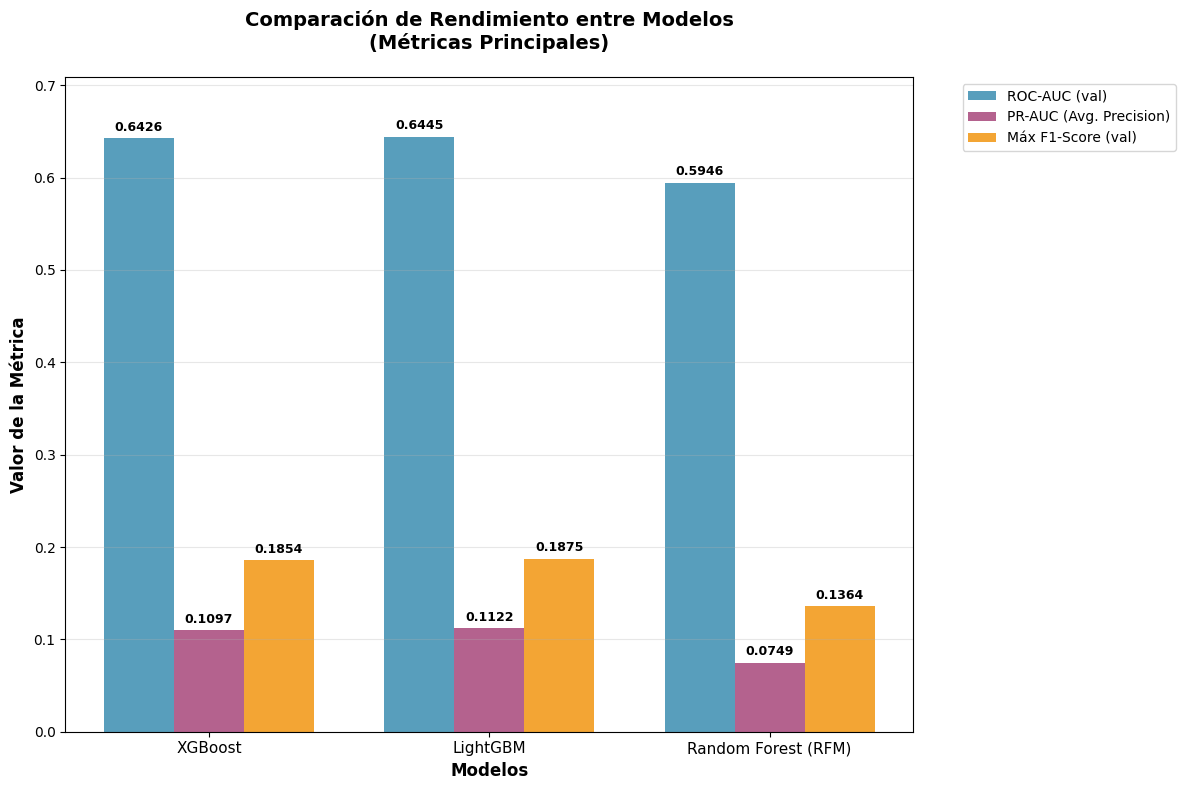

In [3]:
plt.figure(figsize=(12, 8))

# Preparar datos para el gráfico de barras agrupadas
modelos = df_viz['Modelo']
metricas_principales = ['ROC-AUC (val)', 'PR-AUC (Avg. Precision)', 'Máx F1-Score (val)']

# Configurar posiciones de las barras
x = np.arange(len(modelos))
width = 0.25

# Crear las barras agrupadas
colors = ['#2E86AB', '#A23B72', '#F18F01']
for i, metrica in enumerate(metricas_principales):
    valores = df_viz[metrica]
    bars = plt.bar(x + i*width, valores, width, label=metrica, color=colors[i], alpha=0.8)
    
    # Agregar valores en las barras
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

# Configurar el gráfico
plt.xlabel('Modelos', fontsize=12, fontweight='bold')
plt.ylabel('Valor de la Métrica', fontsize=12, fontweight='bold')
plt.title('Comparación de Rendimiento entre Modelos\n(Métricas Principales)', fontsize=14, fontweight='bold', pad=20)
plt.xticks(x + width, modelos, fontsize=11)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, max(df_viz[metricas_principales].max()) * 1.1)

plt.tight_layout()
plt.show()

### 2. Gráfico de Radar (Spider Chart) - Perfil Completo de Rendimiento

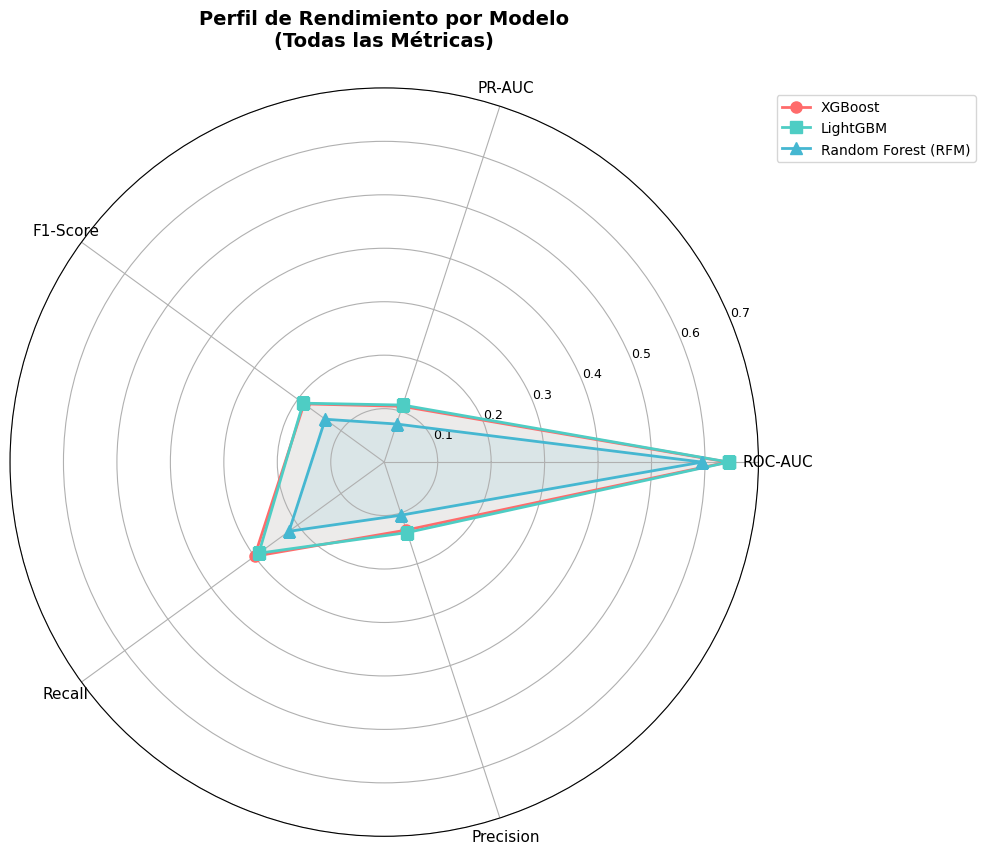

In [4]:
import math

# Configurar el gráfico de radar
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Métricas para el radar (todas las métricas)
metricas_radar = ['ROC-AUC (val)', 'PR-AUC (Avg. Precision)', 'Máx F1-Score (val)', 'Recall @ Máx F1', 'Precision @ Máx F1']
etiquetas_radar = ['ROC-AUC', 'PR-AUC', 'F1-Score', 'Recall', 'Precision']

# Ángulos para cada métrica
angulos = [n / float(len(metricas_radar)) * 2 * math.pi for n in range(len(metricas_radar))]
angulos += angulos[:1]  # Completar el círculo

# Colores para cada modelo
colores_modelos = ['#FF6B6B', '#4ECDC4', '#45B7D1']
markers = ['o', 's', '^']

# Crear el gráfico para cada modelo
for i, modelo in enumerate(df_viz['Modelo']):
    valores = [df_viz.iloc[i][metrica] for metrica in metricas_radar]
    valores += valores[:1]  # Completar el círculo
    
    ax.plot(angulos, valores, linewidth=2, linestyle='solid', label=modelo, 
            color=colores_modelos[i], marker=markers[i], markersize=8)
    ax.fill(angulos, valores, alpha=0.1, color=colores_modelos[i])

# Configurar las etiquetas de los ejes
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(etiquetas_radar, fontsize=11)

# Configurar los valores radiales
ax.set_ylim(0, 0.7)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7'], fontsize=9)
ax.grid(True)

# Título y leyenda
plt.title('Perfil de Rendimiento por Modelo\n(Todas las Métricas)', size=14, fontweight='bold', pad=30)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

### 3. Scatter Plot - Trade-off Precision vs Recall

C:\Users\josue\AppData\Local\Temp\ipykernel_13740\2204026842.py:29: RuntimeWarning: divide by zero encountered in divide
  y_line = (f1_level * x_line) / (2 * x_line - f1_level)


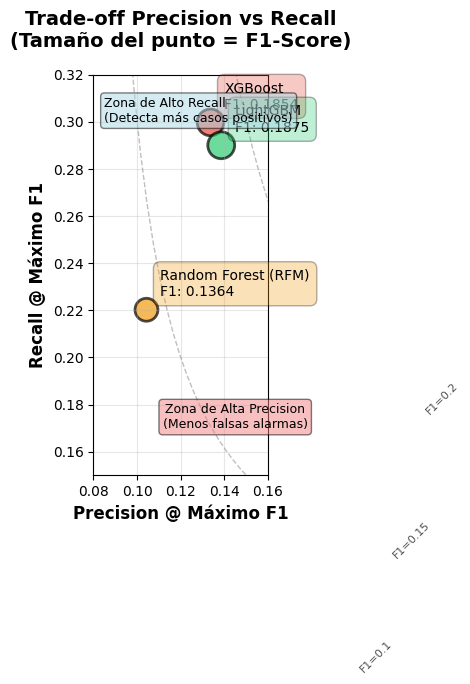

In [5]:
plt.figure(figsize=(10, 8))

# Datos para el scatter plot
precision_vals = df_viz['Precision @ Máx F1']
recall_vals = df_viz['Recall @ Máx F1']
f1_vals = df_viz['Máx F1-Score (val)']
modelos = df_viz['Modelo']

# Colores y tamaños
colores_scatter = ['#E74C3C', '#2ECC71', '#F39C12']
sizes = (f1_vals * 2000)  # Escalar el tamaño según F1-Score

# Crear el scatter plot
scatter = plt.scatter(precision_vals, recall_vals, s=sizes, c=colores_scatter, alpha=0.7, edgecolors='black', linewidths=2)

# Agregar etiquetas para cada punto
for i, modelo in enumerate(modelos):
    plt.annotate(f'{modelo}\nF1: {f1_vals.iloc[i]:.4f}', 
                (precision_vals.iloc[i], recall_vals.iloc[i]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc=colores_scatter[i], alpha=0.3),
                fontsize=10, ha='left')

# Líneas de referencia para diferentes niveles de F1
f1_levels = [0.1, 0.15, 0.2]
x_line = np.linspace(0.05, 0.35, 100)

for f1_level in f1_levels:
    y_line = (f1_level * x_line) / (2 * x_line - f1_level)
    # Solo mostrar valores válidos (positivos)
    valid_mask = (y_line > 0) & (y_line <= 1) & (x_line > 0)
    plt.plot(x_line[valid_mask], y_line[valid_mask], '--', alpha=0.5, color='gray', linewidth=1)
    
    # Etiqueta para la línea de F1
    if len(x_line[valid_mask]) > 0:
        mid_idx = len(x_line[valid_mask]) // 2
        if mid_idx < len(x_line[valid_mask]):
            plt.text(x_line[valid_mask][mid_idx], y_line[valid_mask][mid_idx], 
                    f'F1={f1_level}', fontsize=8, alpha=0.7, rotation=45)

# Configurar el gráfico
plt.xlabel('Precision @ Máximo F1', fontsize=12, fontweight='bold')
plt.ylabel('Recall @ Máximo F1', fontsize=12, fontweight='bold')
plt.title('Trade-off Precision vs Recall\n(Tamaño del punto = F1-Score)', fontsize=14, fontweight='bold', pad=20)

# Configurar límites y grilla
plt.xlim(0.08, 0.16)
plt.ylim(0.15, 0.32)
plt.grid(True, alpha=0.3)

# Agregar texto explicativo
plt.text(0.085, 0.30, 'Zona de Alto Recall\n(Detecta más casos positivos)', 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.5),
         fontsize=9, ha='left')

plt.text(0.145, 0.17, 'Zona de Alta Precision\n(Menos falsas alarmas)', 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.5),
         fontsize=9, ha='center')

plt.tight_layout()
plt.show()

### Interpretación de las Visualizaciones

**Gráfico de Barras Agrupadas:** Muestra claramente que LightGBM supera a los otros modelos en las tres métricas principales, seguido muy de cerca por XGBoost. Random Forest (RFM) tiene un rendimiento notablemente inferior.

**Gráfico de Radar:** Permite visualizar el "perfil" completo de cada modelo. Se observa que LightGBM y XGBoost tienen formas similares pero LightGBM es ligeramente superior en la mayoría de dimensiones. Random Forest muestra un perfil más "comprimido" hacia el centro.

**Scatter Plot Precision vs Recall:** Revela el trade-off fundamental en clasificación. XGBoost logra el mayor Recall (detecta más clientes leales) pero con menor Precision. LightGBM encuentra un mejor equilibrio. El tamaño de los puntos confirma que LightGBM logra el mejor F1-Score general.